# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from timeit import default_timer as timer

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df = df[(df.job != 'unknown') & (df.marital != 'unknown') & (df.education != 'unknown') & (df.default != 'unknown') & (df.housing != 'unknown') & (df.loan != 'unknown')]
print(f"Cleaned rows: {df.shape[0]}")

Cleaned rows: 30488


In [7]:
fraction_subscribed = df[df.y == 'yes'].shape[0] / df.shape[0]
print(f"Percentage of subscriptions: {100 * fraction_subscribed:.2f}%")

Percentage of subscriptions: 12.66%


#### Feature Encoding
* One Hot Encoding: job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y
* Pass through the rest

#### Dropping unknown values
* Drop any columns where categorical value is 'unknown'. This will reduce the total dataset to 30,488 rows which should be enough for analysis.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective
The business objective is to create a model that predicts which customers would be likely to subscribe to a term deposit. Contacting customers who are unlikely to respond positively can result in customer dissatisfaction and wasted resources. Therefore the marketing campaigns can save time, money, and user trust by targeting customers that are likely to convert.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [8]:
ordinal_ohe = make_column_transformer(
      (OneHotEncoder(drop = 'if_binary'), ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']),
      remainder = 'passthrough',
      verbose_feature_names_out = False
)
df_encoded = pd.DataFrame(ordinal_ohe.fit_transform(df), columns=ordinal_ohe.get_feature_names_out())
df_encoded.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,56.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0


In [9]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30488 entries, 0 to 30487
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   job_admin.                     30488 non-null  float64
 1   job_blue-collar                30488 non-null  float64
 2   job_entrepreneur               30488 non-null  float64
 3   job_housemaid                  30488 non-null  float64
 4   job_management                 30488 non-null  float64
 5   job_retired                    30488 non-null  float64
 6   job_self-employed              30488 non-null  float64
 7   job_services                   30488 non-null  float64
 8   job_student                    30488 non-null  float64
 9   job_technician                 30488 non-null  float64
 10  job_unemployed                 30488 non-null  float64
 11  marital_divorced               30488 non-null  float64
 12  marital_married                30488 non-null 

In [10]:
X_bank_info = df_encoded.iloc[:, :24] # Keep first 23 columns, the encoded bank information.
y = df_encoded['y_yes']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
# Stratified to get an even split of positive responses since the classes are unbalanced (12% acceptance rate).
X_train, X_test, y_train, y_test = train_test_split(X_bank_info, y, test_size=0.25, random_state=42, stratify=y)
print("Stratified training and test splits have roughly the same subscription rate")
train_subscription_rate = y_train[y_train == 1].shape[0] / y_train.shape[0]
print(f"Training subscription rate {train_subscription_rate}")
test_subscription_rate = y_test[y_test == 1].shape[0] / y_test.shape[0]
print(f"Test subscription rate {test_subscription_rate}")

Stratified training and test splits have roughly the same subscription rate
Training subscription rate 0.12656345666054403
Test subscription rate 0.12660718971398582


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [12]:
# The baseline predicts the majority class which is 'no'. 
# The score for the baseline prediction is equal to the fraction of test data that said no.
baseline_accuracy = 1 - test_subscription_rate
print(f"Baseline accuracy: {baseline_accuracy:.5f}")

Baseline accuracy: 0.87339


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [13]:
lr = LogisticRegression().fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [14]:
lr.score(X_test, y_test)

0.8733928102860141

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [15]:
def measure_model(model, model_name, result, X_train_, y_train_, X_test_, y_test_):
    start = timer()
    model.fit(X_train_, y_train_)
    end = timer()
    result['Model'].append(model_name)
    result['Train Time'].append(end - start)
    result['Train Accuracy'].append(model.score(X_train_, y_train_))
    result['Test Accuracy'].append(model.score(X_test_, y_test_))

In [16]:
result_dict = {'Model': [], 'Train Time': [], 'Train Accuracy': [], 'Test Accuracy': []}
measure_model(KNeighborsClassifier(), 'KNN', result_dict, X_train.values, y_train, X_test.values, y_test) # Bug workaround https://github.com/scikit-learn/scikit-learn/issues/26768#issuecomment-1676406055
measure_model(LogisticRegression(), 'Logistic Regression', result_dict, X_train, y_train, X_test, y_test)
measure_model(DecisionTreeClassifier(), 'Decision Tree', result_dict, X_train, y_train, X_test, y_test)
measure_model(SVC(), 'SVM', result_dict, X_train, y_train, X_test, y_test)
test_df = pd.DataFrame(result_dict).set_index('Model')
test_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
KNN,0.004392,0.859486,0.858174
Logistic Regression,0.068182,0.873437,0.873393
Decision Tree,0.033006,0.875098,0.871162
SVM,5.051070,0.873480,0.873393


#### Model Comparisons
The best results of these models only match the baseline (always predict no) which scored 0.87339. In the case of the LogisticRegression, that's because it actually always predicts no.

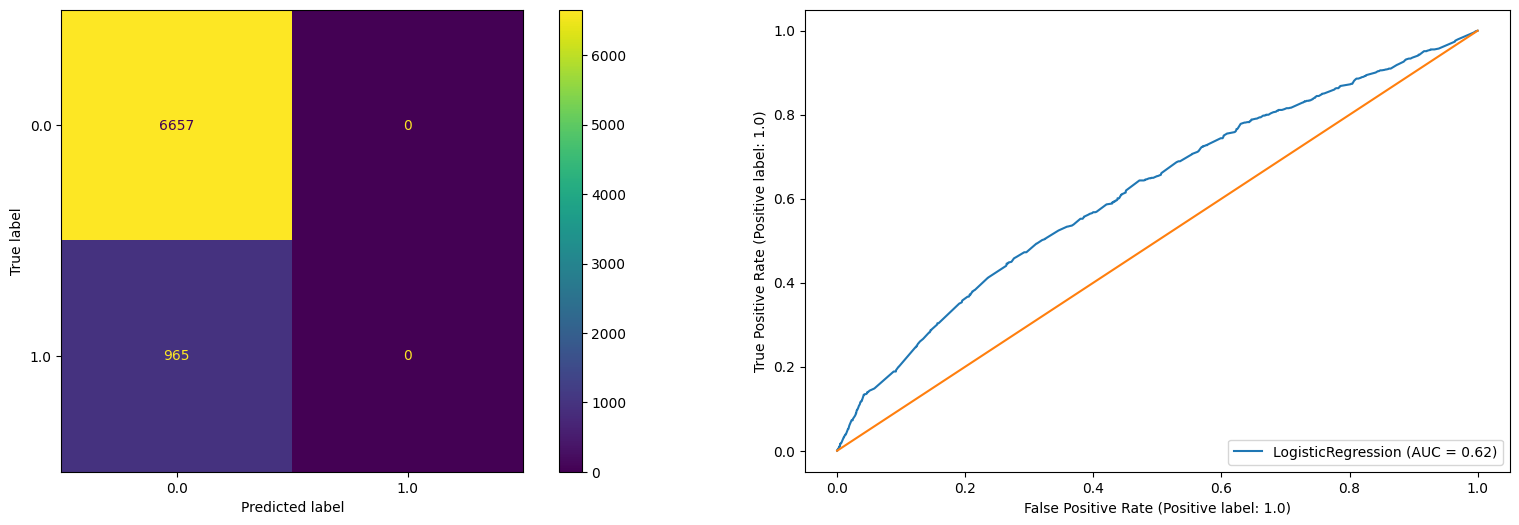

In [17]:
logisticRegression = LogisticRegression().fit(X_train, y_train)
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(logisticRegression, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(logisticRegression, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [18]:
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42), max_features=10)

In [19]:
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('extractor', extractor),
    ('model', LogisticRegression(random_state=42))
])
logistic_params = {'model__max_iter': [100, 1000, 10000]}
logistic_grid = GridSearchCV(logistic_pipeline, n_jobs=8, param_grid=logistic_params, scoring='roc_auc')
logistic_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('extractor',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     random_state=42,
                                                                                     solver='liblinear'),
                                                        max_features=10)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=8, param_grid={'model__max_iter': [100, 1000, 10000]},
             scoring='roc_auc')

In [20]:
logistic_grid.best_estimator_.score(X_test, y_test)

0.8733928102860141

In [21]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('extractor', extractor),
    ('model', KNeighborsClassifier())
])
knn_params = {'model__n_neighbors': np.arange(2,20)}
knn_grid = GridSearchCV(knn_pipeline, n_jobs=8, param_grid=knn_params, scoring='roc_auc')
# knn_params = {'n_neighbors': np.arange(2,20)}
# knn_grid = GridSearchCV(KNeighborsClassifier(), n_jobs=8, param_grid=knn_params, scoring='roc_auc')
knn_grid.fit(X_train.values, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('extractor',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     random_state=42,
                                                                                     solver='liblinear'),
                                                        max_features=10)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid={'model__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
             scoring='roc_auc')

In [22]:
knn_grid.best_estimator_.score(X_test.values, y_test)

0.8728680136447127

In [23]:
pca_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', SVC())
])
pca_svm_params = {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'pca__n_components': [3, 4, 5]}
pca_svm_grid = GridSearchCV(pca_svm_pipeline, n_jobs=8, param_grid=pca_svm_params, scoring='roc_auc')
pca_svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('model', SVC())]),
             n_jobs=8,
             param_grid={'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'pca__n_components': [3, 4, 5]},
             scoring='roc_auc')

In [24]:
pca_svm_grid.best_estimator_.score(X_test, y_test)

0.8733928102860141

In [25]:
pca_lgr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', LogisticRegression())
])
pca_lgr_params = {'model__max_iter': [100, 1_000, 10_000], 'pca__n_components': [3, 4, 5]}
pca_lgr_grid = GridSearchCV(pca_lgr_pipeline, n_jobs=8, param_grid=pca_lgr_params, scoring='roc_auc')
pca_lgr_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=8,
             param_grid={'model__max_iter': [100, 1000, 10000],
                         'pca__n_components': [3, 4, 5]},
             scoring='roc_auc')

In [26]:
pca_lgr_grid.best_estimator_.score(X_test, y_test)

0.8733928102860141

In [27]:
dt_params = {'max_depth': np.arange(3, 15)}
dt_grid = GridSearchCV(DecisionTreeClassifier(), n_jobs=8, param_grid=dt_params, scoring='roc_auc')
dt_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='roc_auc')

In [28]:
best_dt_estimator = dt_grid.best_estimator_
print(f"Decision Tree score: {best_dt_estimator.score(X_test, y_test)} at depth {dt_grid.best_params_['max_depth']}")

Decision Tree score: 0.8735240094463396 at depth 5


#### Modeling with only bank data results
After trying several approaches for automated feature selection and PCA, a decision tree with depth 5 was the only one better than baseline and it only predicts 3 true positives.

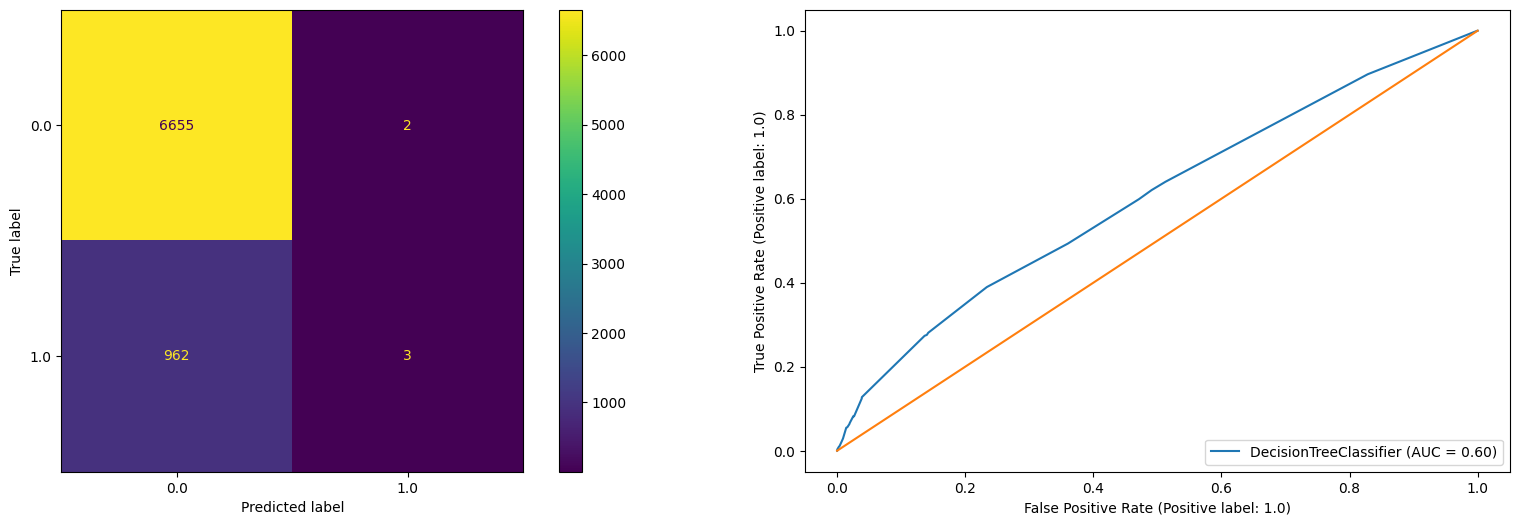

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(best_dt_estimator, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(best_dt_estimator, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

#### Adding other features
In the paper, they experienced the best results using SVM and including several of the call center features. Let's bring the other features back and see if that improves classification.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(['y_yes', 'duration'], axis=1), y, test_size=0.25, random_state=42, stratify=y)

In [31]:
dt_params = {'max_depth': np.arange(3, 15)}
dt_grid = GridSearchCV(DecisionTreeClassifier(), n_jobs=8, param_grid=dt_params, scoring='roc_auc')
dt_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='roc_auc')

In [32]:
best_dt_estimator = dt_grid.best_estimator_
print(f"Decision Tree score: {best_dt_estimator.score(X_test, y_test)} at depth {dt_grid.best_params_['max_depth']}")

Decision Tree score: 0.8855943321962739 at depth 6


In [33]:
svm_extractor_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('extractor', extractor),
    ('model', SVC())
])
svm_extractor_params = {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'extractor__max_features': np.arange(7, 9)}
svm_extractor_grid = GridSearchCV(svm_extractor_pipeline, n_jobs=8, param_grid=svm_extractor_params, scoring='roc_auc')
svm_extractor_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('extractor',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     random_state=42,
                                                                                     solver='liblinear'),
                                                        max_features=10)),
                                       ('model', SVC())]),
             n_jobs=8,
             param_grid={'extractor__max_features': array([7, 8]),
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc')

In [34]:
svm_extractor_grid.best_estimator_.score(X_test, y_test)

0.883495145631068

In [35]:
svm_extractor_grid.best_params_['extractor__max_features']

8

In [36]:
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('extractor', extractor),
    ('model', LogisticRegression(random_state=42))
])

In [37]:
logistic_params = {'model__max_iter': [100, 1000, 10000], 'extractor__max_features': np.arange(7, 10)}
logistic_grid = GridSearchCV(logistic_pipeline, n_jobs=8, param_grid=logistic_params, scoring='roc_auc')
logistic_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('extractor',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     random_state=42,
                                                                                     solver='liblinear'),
                                                        max_features=10)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=8,
             param_grid={'extractor__max_features': array([7, 8, 9]),
                         'model__max_iter': [100, 1000, 10000]},
             scoring='roc_auc')

In [38]:
best_logistic_estimator = logistic_grid.best_estimator_
best_logistic_estimator.score(X_test, y_test)

0.8861191288375755

In [39]:
logistic_grid.best_params_['extractor__max_features']

9

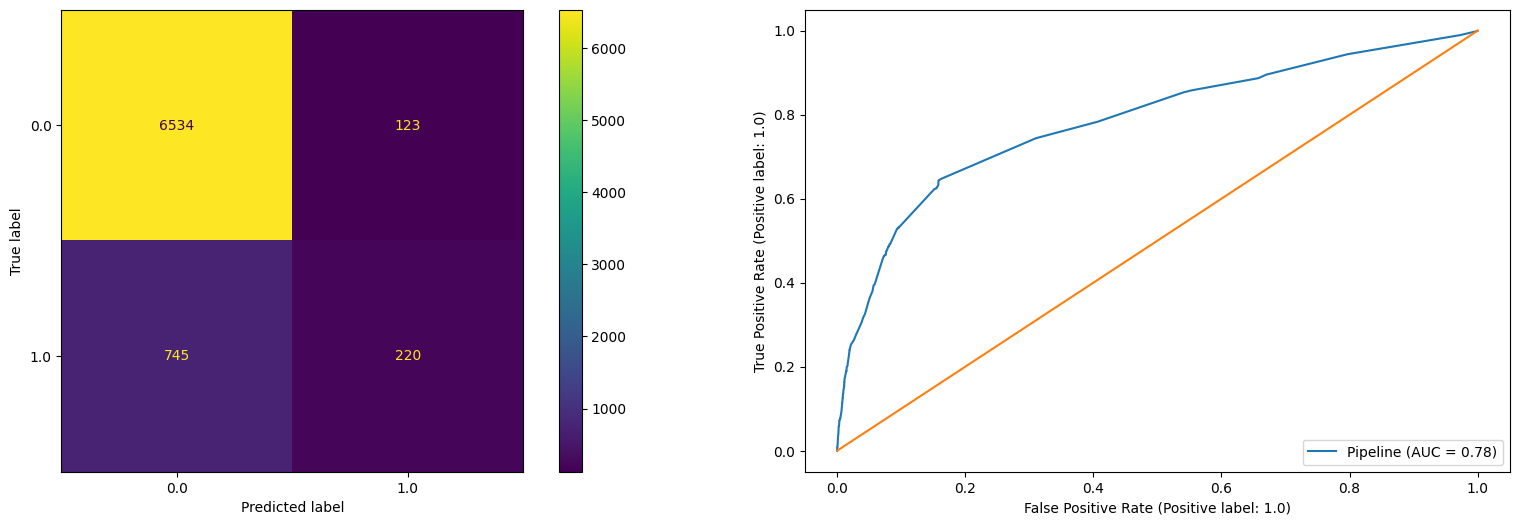

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(best_logistic_estimator, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(best_logistic_estimator, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

In [41]:
feature_names = X_train.columns
selected_features =feature_names[ [int(i[1:]) for i in best_logistic_estimator.named_steps['extractor'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': best_logistic_estimator.named_steps['model'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df

,feature,coefs
5,emp.var.rate,1.569390
6,cons.price.idx,0.881946
0,contact_telephone,0.324398
4,pdays,0.285775
8,nr.employed,0.249384
3,month_may,0.247885
7,cons.conf.idx,0.193988
2,month_mar,0.173396
1,month_jun,0.129559


## Findings
We have very unbalanced data with only 12.66% in the positive class. I omitted KNN for this round because it is unlikely to perform well with such unbalanced data. Running a grid search on the Decision Tree, Support Vector, and Logistic Regression models produced better results when they were exposed to all of the data. Logistic regression performed best once tuned and exposed to most of the data. When using the original banking customer data only, none of the models did better than the baseline.

### Best Model

The model with the highest accuracy was Logistic Regression with a score of 0.8861. That doesn't seem very impressive when compared to baseline of 0.87339, but accuracy doesn't paint the whole picture. Assuming everyone will say no isn't a very useful model. When we look a the recall of the Logistic Regression model, it has much better recall than the baseline at the cost of several false positives. The number of false negatives is way too high. Further tuning might move that bar so that there are fewer false negatives. It would be better to call and be declined than to skip a customer that would've accepted the offer.

### Most Important Features

The best performing model in the analysis was a logistic regression using these features in descending order of importance: 
* emp.var.rate - Quarterly employment variability rate
* cons.price.idx - Monthly consumer price index
* contact_telephone - Called on a land line
* pdays - Number of days that have passed since the last call
* nr.employed - Quarterly number of employees.
* cons.conf.idx - Monthly consumer confidence index
* Being in the spring/summer March, May, and June.

### Actionable Items
* These marketing operations will perform better when the customers feel good about the economy. When consumer confidence is high, they're more likely to accept the offer.
* Being called on a telephone is more likely to succeed than cellular.
* Waiting long enough between calls to the customer will increase the probability that they're receptive.
* Call customers late in spring and early in summer.